# 9.	 Implementation of RNN model for Stock Price Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

import datetime


In [2]:
import yfinance as yf

stock_data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
stock_data = stock_data[['Close']]  # Only use 'Close' prices
stock_data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Price,Close
Ticker,AAPL
Date,


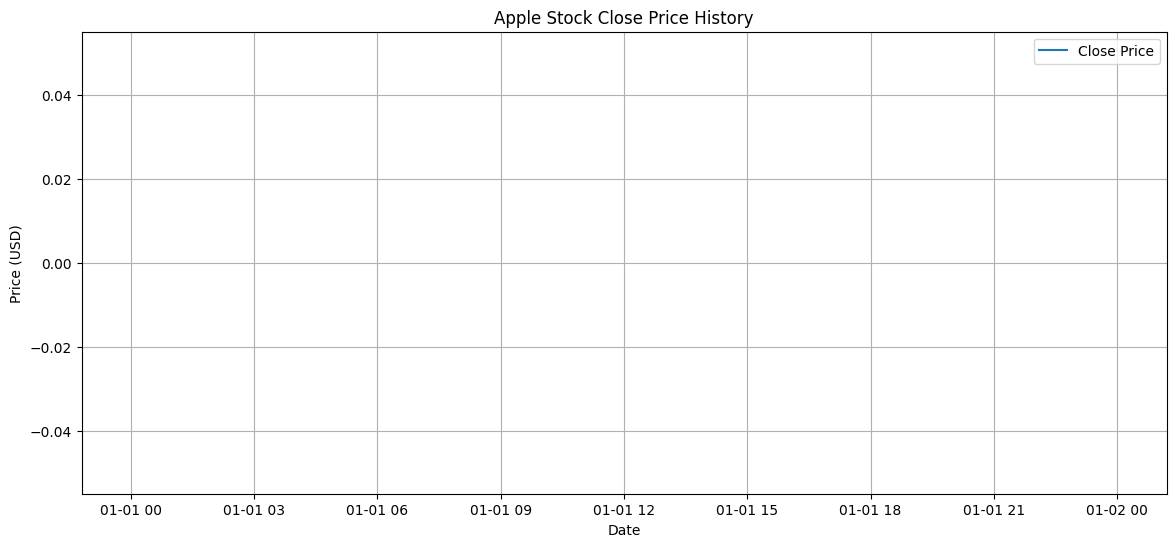

In [3]:
plt.figure(figsize=(14, 6))
plt.plot(stock_data['Close'], label='Close Price')
plt.title('Apple Stock Close Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
c:\Users\Shlok Sonkusare\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Shlok Sonkusare\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


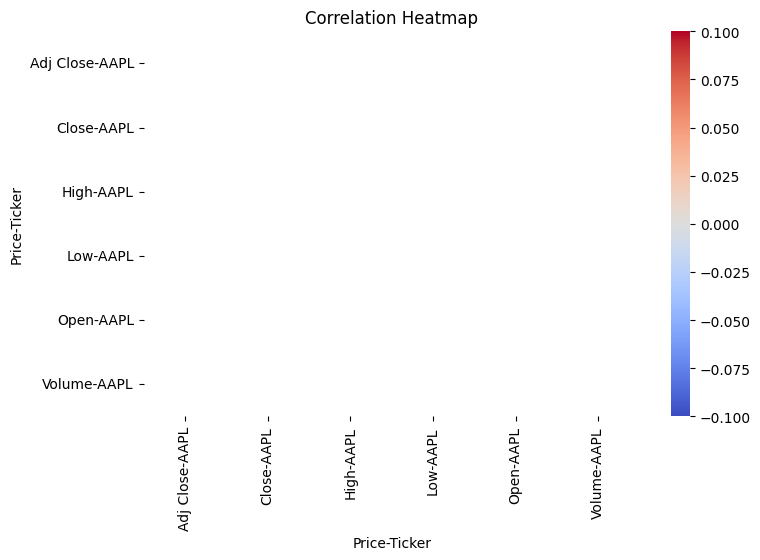

In [4]:

full_data = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
plt.figure(figsize=(8, 5))
sns.heatmap(full_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

scaled_data[:5] 


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Reshape to [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)
X.shape, y.shape


((2455, 60, 1), (2455,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape


((1964, 60, 1), (491, 60, 1))

In [ ]:
model = Sequential()
model.add(SimpleRNN(50, return_sequences=False, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
62/62 [==============================] - 1s 7ms/step - loss: 0.0047 - val_loss: 0.0076
Epoch 2/20
62/62 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0090
Epoch 3/20
62/62 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 4/20
62/62 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 5/20
62/62 [==============================] - 0s 5ms/step - loss: 9.8127e-04 - val_loss: 7.4278e-04
Epoch 6/20
62/62 [==============================] - 0s 5ms/step - loss: 8.8623e-04 - val_loss: 7.1458e-04
Epoch 7/20
62/62 [==============================] - 0s 5ms/step - loss: 8.2556e-04 - val_loss: 7.3582e-04
Epoch 8/20
62/62 [==============================] - 0s 5ms/step - loss: 7.9555e-04 - val_loss: 5.7668e-04
Epoch 9/20
62/62 [==============================] - 0s 5ms/step - loss: 6.2238e-04 - val_loss: 3.8706e-04
Epoch 10/20
62/62 [==============================] - 0s 5ms/step - loss: 6.110

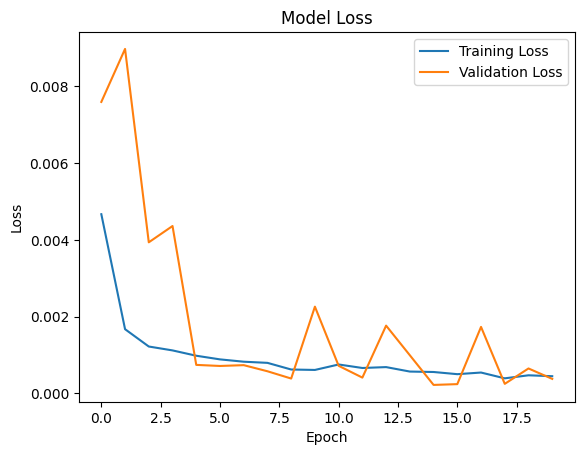

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_predicted = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


16/16 [==============================] - 0s 3ms/step


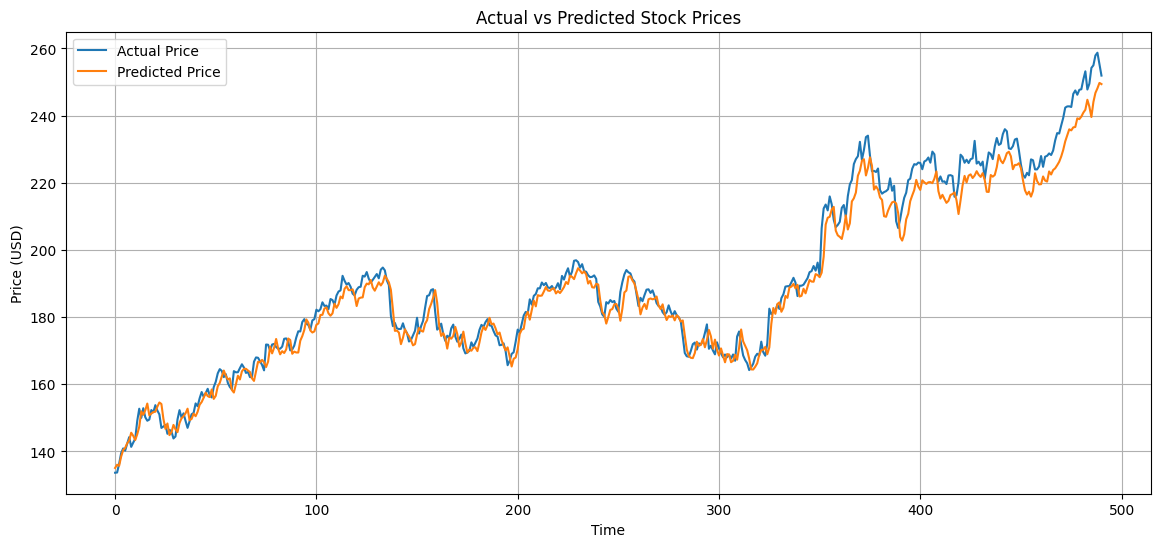

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_actual, label='Actual Price')
plt.plot(y_predicted, label='Predicted Price')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(y_actual, y_predicted))
print(f'Root Mean Squared Error: {rmse:.4f}')


Root Mean Squared Error: 4.6301


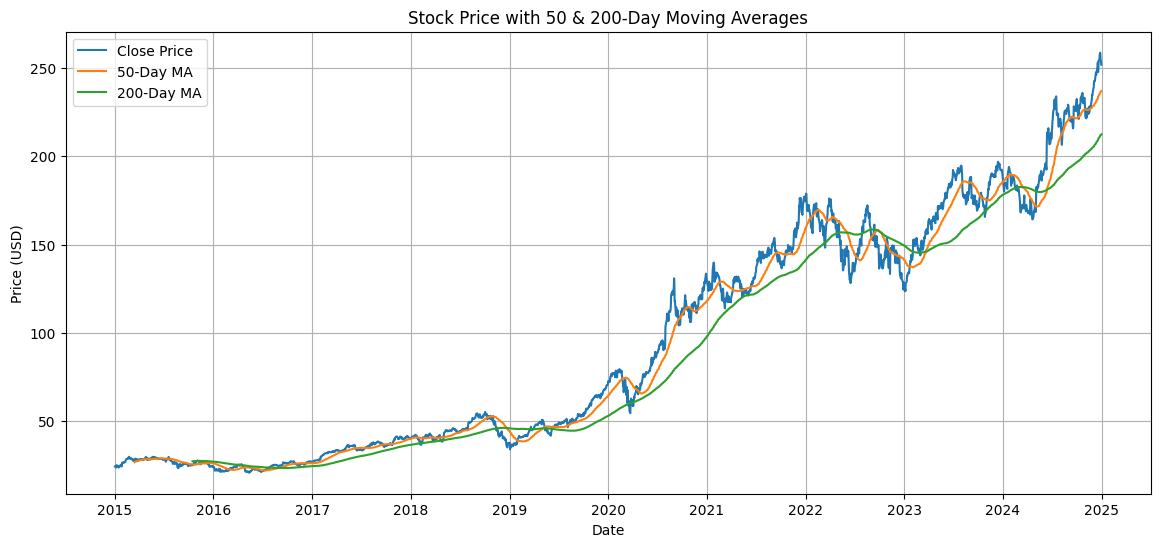

In [ ]:
plt.figure(figsize=(14, 6))
stock_data['MA50'] = stock_data['Close'].rolling(50).mean()
stock_data['MA200'] = stock_data['Close'].rolling(200).mean()

plt.plot(stock_data['Close'], label='Close Price')
plt.plot(stock_data['MA50'], label='50-Day MA')
plt.plot(stock_data['MA200'], label='200-Day MA')
plt.title('Stock Price with 50 & 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
